# TRAINING & EVALUATION

## Imports & Data

In [18]:
import sys

# Add the folder path where rouge is installed (change this to your actual path)
sys.path.append(r"C:\Users\Ait El Mouddene\miniconda3\envs\py311-env\Lib\site-packages")

In [26]:
!pip install rouge-score

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=25023 sha256=b052a997c601e86b10beeeac0ef0e28997d995be815c89d0e9b87e1afc643b94
  Stored in directory: c:\users\ait el mouddene\appdata\local\pip\cache\wheels\1e\19\43\8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score

   -------------------- ------------------- 1/2 [rouge-score]
   ---------------------------------------- 2/2 [rouge-score]



  DEPRECATION: Building 'rouge-score' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'rouge-score'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [29]:
from rouge_score import rouge_scorer

In [1]:
import json
from sklearn.cluster import KMeans
from math import ceil
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [2]:
df = pd.read_parquet("preprocessed_legal_data.parquet")

In [3]:
# Open the JSON file for reading
with open('all_features_combined.json', 'r') as file:
    all_features_combined = json.load(file)  # Parse JSON into a Python dictionary or list

In [4]:
all_features_cleaned, all_labels = all_features_combined["all_features"], all_features_combined["all_labels"]

## Utils

In [5]:
def get_rouge_metrics_by_doc_idx(doc_idx, generated_summary):
    rouge = Rouge()
    
    reference = df["summary/long"][doc_idx]
    hypothesis = generated_summary
    
    return rouge.get_scores(hypothesis, reference)[0]  # returns list of one dict


In [32]:
def evaluate_summaries(summary_df):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge1_p, rouge1_r, rouge1_f = [], [], []
    rouge2_p, rouge2_r, rouge2_f = [], [], []
    rougeL_p, rougeL_r, rougeL_f = [], [], []

    for _, row in tqdm(summary_df.iterrows(), total=len(summary_df), desc="Evaluating ROUGE"):
        gen = row["generated_summary"]
        ref = row["summary/long"]

        scores = scorer.score(ref, gen)

        rouge1_p.append(scores["rouge1"].precision)
        rouge1_r.append(scores["rouge1"].recall)
        rouge1_f.append(scores["rouge1"].fmeasure)

        rouge2_p.append(scores["rouge2"].precision)
        rouge2_r.append(scores["rouge2"].recall)
        rouge2_f.append(scores["rouge2"].fmeasure)

        rougeL_p.append(scores["rougeL"].precision)
        rougeL_r.append(scores["rougeL"].recall)
        rougeL_f.append(scores["rougeL"].fmeasure)

    results = {
        "ROUGE-1": {
            "precision": np.mean(rouge1_p),
            "recall":    np.mean(rouge1_r),
            "f1":        np.mean(rouge1_f)
        },
        "ROUGE-2": {
            "precision": np.mean(rouge2_p),
            "recall":    np.mean(rouge2_r),
            "f1":        np.mean(rouge2_f)
        },
        "ROUGE-L": {
            "precision": np.mean(rougeL_p),
            "recall":    np.mean(rougeL_r),
            "f1":        np.mean(rougeL_f)
        }
    }

    return results

In [7]:
def get_selected_text(row):
    selected_sentences = [
        sent for sent, pred in zip(row["sentence"], row["prediction"]) if pred == 1
    ]
    return " ".join(selected_sentences)

## K-MEANS

### Test Elbow Method

In [8]:
def compute_avg_inertia(doc_features_list, k_values):
    """
    For each k in k_values, fits KMeans on each doc in doc_features_list
    and returns the average inertia across docs.
    """
    avg_inertias = {}
    for k in k_values:
        inertias = []
        for feats in doc_features_list:
            # feats is a list of dicts; convert to array
            X = np.array([[v for v in sent.values()] for sent in feats])
            if k <= X.shape[0]:
                km = KMeans(n_clusters=k, random_state=42, n_init='auto')
                km.fit(X)
                inertias.append(km.inertia_)
        avg_inertias[k] = np.mean(inertias) if inertias else np.nan
    return avg_inertias

In [9]:
k_values = list(range(1, 11))
avg_inertias = compute_avg_inertia(all_features_cleaned[:10], k_values)

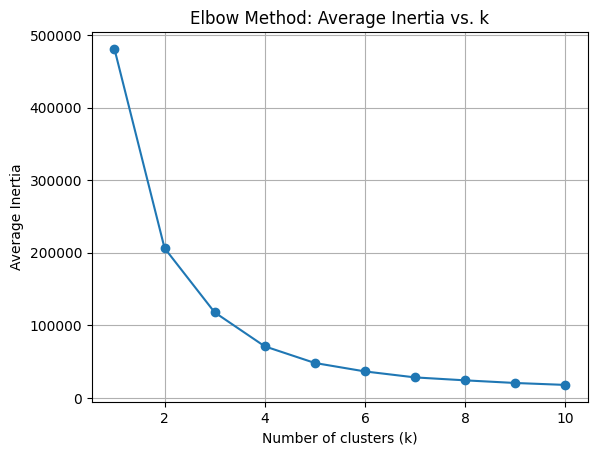

In [10]:
# 4) Plot the elbow curve
plt.figure()
plt.plot(k_values, [avg_inertias[k] for k in k_values], marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Inertia')
plt.title('Elbow Method: Average Inertia vs. k')
plt.grid(True)
plt.show()

### Clustering

In [11]:
def get_doc_clusters(doc_features, k):
    if not doc_features:
        print("No features to cluster.")
        return None, None

    # Convert list of dicts to numpy array
    X_doc = np.array([[v for v in sent.values()] for sent in doc_features])

    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_doc)

    # Return cluster labels and cluster centers
    return kmeans.labels_, kmeans.cluster_centers_

In [12]:
def get_wanted_cluster(labels, k):
    count_k = []
    for cl in range(k):
        count_k.append(np.sum(labels == cl))  # Count how many times each label appears
    min_index = count_k.index(min(count_k))  # Index of the cluster with the fewest items
    return min_index

In [13]:
def get_doc_summary_from_kmeans(df, doc_features, doc_id, k=4):
    summary_sentences = ""
    labels, centers = get_doc_clusters(doc_features, k)
    cluster_2_indexes = np.where(labels == get_wanted_cluster(labels, k))[0]
    for idx, sentence in enumerate(df["sentences"][doc_id]):
        if idx in cluster_2_indexes:
            summary_sentences += ' ' + sentence
    return summary_sentences.strip()

In [14]:
def build_summary_comparison_df(df, all_features_cleaned, k=4):

    results = []

    for doc_idx in tqdm(range(len(df)), desc="Generating summaries"):
        feats = all_features_cleaned[doc_idx]
        gen_sum = get_doc_summary_from_kmeans(df, feats, doc_idx, k=k)
        results.append({
            "doc_id": df.iloc[doc_idx]["id"],
            "generated_summary": gen_sum,
            "summary/long": df.iloc[doc_idx]["summary/long"]
        })

    summary_df = pd.DataFrame(results)
    return summary_df.set_index("doc_id")

In [15]:
summary_df = build_summary_comparison_df(df, all_features_cleaned, k=4)

Generating summaries: 100%|██████████████████████████████████████████████████████████| 318/318 [00:06<00:00, 52.38it/s]


### Evaluation

In [33]:
results = evaluate_summaries(summary_df)
print("Average ROUGE Scores:")
for metric, scores in results.items():
    print(f"{metric}:")
    print(f"  Precision: {scores['precision']:.4f}")
    print(f"  Recall:    {scores['recall']:.4f}")
    print(f"  F1-score:  {scores['f1']:.4f}")

Evaluating ROUGE: 100%|██████████████████████████████████████████████████████████████| 318/318 [04:13<00:00,  1.25it/s]

Average ROUGE Scores:
ROUGE-1:
  Precision: 0.2112
  Recall:    0.5160
  F1-score:  0.2573
ROUGE-2:
  Precision: 0.0550
  Recall:    0.1519
  F1-score:  0.0690
ROUGE-L:
  Precision: 0.0954
  Recall:    0.2364
  F1-score:  0.1154


## Logistic Regression

### Flatten Data for Training

In [34]:
def flatten_features_for_training(all_features, all_labels):
    X = []
    y = []
    
    for doc_idx in range(len(all_features)):
        for sent_idx in range(len(all_features[doc_idx])):
            # Convert dictionary to list of values
            feature_vector = list(all_features[doc_idx][sent_idx].values())
            X.append(feature_vector)
            y.append(all_labels[doc_idx][sent_idx])
    
    return np.array(X), np.array(y)

In [35]:
X, y = flatten_features_for_training(all_features_cleaned, all_labels)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [36]:
flattened_data = []

for idx, row in df.iterrows():
    doc_id = row["id"]
    sentences = row["sentences"]  # or "sentences_tf_idf"
    
    for sent_idx, sentence in enumerate(sentences):
        flattened_data.append({
            "doc_id": doc_id,
            "sent_idx": sent_idx,
            "sentence": sentence,
        })
      
flat_df = pd.DataFrame(flattened_data)
X_train_, X_test_ = train_test_split(flat_df, test_size=0.2, shuffle=False)

### Correlation Matrics

In [37]:
# Rebuild column names from one example (assuming all features have same keys)
feature_keys = list(all_features_cleaned[0][0].keys())

# Create a DataFrame
df_features = pd.DataFrame(X, columns=feature_keys)
df_features['label'] = y  # Add the target variable

In [38]:
correlation_matrix = df_features.corr(numeric_only=True)
correlation_matrix["label"]

avg_tfidf                 0.533351
max_tfidf                -0.267608
sum_tfidf                 0.533351
centroid_similarity       0.333321
rel_position             -0.012456
is_first_quarter          0.021066
is_last_quarter           0.004014
is_first                 -0.001498
is_last                  -0.000633
sentence_length           0.439901
sentence_parity          -0.000346
noun_ratio                0.167712
verb_ratio                0.133050
adj_ratio                 0.124127
adv_ratio                 0.038677
prop_noun_ratio          -0.159314
num_ratio                -0.173148
legal_term_count          0.415760
count_act_mention         0.102533
count_company_mentions    0.006853
count_conditions          0.167673
count_durations           0.081862
count_constraints         0.157124
count_num_dates           0.089968
label                     1.000000
Name: label, dtype: float64

### Training & Prediction

In [39]:
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [41]:
y_pred = clf.predict(X_test)

In [42]:
X_test_["prediction"] = y_pred

### Preparing DF

In [48]:
grouped = X_test_.groupby("doc_id").agg(list)

In [49]:
grouped["generated_summary"] = grouped.apply(get_selected_text, axis=1)

In [50]:
grouped.head(1)

,sent_idx,sentence,prediction,generated_summary
doc_id,,,,
CJ-CO-0002,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[Document 1 Filed 22 February 2016 USDC Colora...,"[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","G.G., E.A.C.W, A.K., T.M., G.C., F.P., E.V. an..."


In [51]:
grouped = grouped.merge(df[["id", "summary/long"]], left_on="doc_id", right_on="id", how="left")
grouped = grouped.set_index("id")

In [52]:
grouped.head(1)

,sent_idx,sentence,prediction,generated_summary,summary/long
id,,,,,
CJ-CO-0002,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[Document 1 Filed 22 February 2016 USDC Colora...,"[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","G.G., E.A.C.W, A.K., T.M., G.C., F.P., E.V. an...","On February 22, 2016, individuals with mental ..."


In [53]:
grouped = grouped.drop(columns=["prediction", "sent_idx", "sentence"])

### Evaluation

Classification Evaluation

In [54]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8668869483124853
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92    105063
           1       0.72      0.54      0.62     26284

    accuracy                           0.87    131347
   macro avg       0.81      0.74      0.77    131347
weighted avg       0.86      0.87      0.86    131347



ROUGE Evaluation

In [55]:
results = evaluate_summaries(grouped)
print("Average ROUGE Scores:")
for metric, scores in results.items():
    print(f"{metric}:")
    print(f"  Precision: {scores['precision']:.4f}")
    print(f"  Recall:    {scores['recall']:.4f}")
    print(f"  F1-score:  {scores['f1']:.4f}")

Evaluating ROUGE: 100%|████████████████████████████████████████████████████████████████| 98/98 [05:33<00:00,  3.40s/it]

Average ROUGE Scores:
ROUGE-1:
  Precision: 0.0832
  Recall:    0.8622
  F1-score:  0.1429
ROUGE-2:
  Precision: 0.0357
  Recall:    0.4194
  F1-score:  0.0622
ROUGE-L:
  Precision: 0.0433
  Recall:    0.4922
  F1-score:  0.0751
